In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import grad, jit, value_and_grad, make_jaxpr, config
from jax import random, profiler, config, debug
from jax.nn import sigmoid
import numpy as np
import jax
import optax

from larndsim.sim_jax import load_data, set_pixel_plane, chop_tracks, load_params, prepare_tracks, simulate, params_loss, id2pixel, get_pixel_coordinates
from larndsim.softdtw_jax import SoftDTW
from numpy.lib import recfunctions as rfn

import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py

jax.config.update('jax_platform_name', 'cpu')
config.update("jax_debug_nans", False)
plt.rcParams['font.size'] = 15

In [16]:
sdtw = SoftDTW(1)

x = jnp.arange(0, 100)

sdtw.pairwise(x, x)

Array(-64.19974, dtype=float32)

In [1]:
# Save chopped tracks
tracks, dtype = load_data('/home/pgranger/larnd-sim/tools/evd/data/single_track.h5')
fields = dtype.names
tracks = chop_tracks(tracks, fields, 100)

with h5py.File('single_track_chopped_100.h5', 'w') as f:
    segments = rfn.unstructured_to_structured(np.array(tracks), dtype, copy=True)
    x_start = np.copy(segments['x_start'] )
    x_end = np.copy(segments['x_end'])
    x = np.copy(segments['x'])
    segments['x_start'] = np.copy(segments['z_start'])
    segments['x_end'] = np.copy(segments['z_end'])
    segments['x'] = np.copy(segments['z'])

    segments['z_start'] = x_start
    segments['z_end'] = x_end
    segments['z'] = x
    print(segments['pixel_plane'])
    f.create_dataset('segments', data=segments)


NameError: name 'load_data' is not defined

In [2]:
#Loading the tracks

ref_params = load_params()
tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/examples/module0_corsika.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_split.h5'
tracks, fields, original_tracks = prepare_tracks(ref_params, tracks_file)
print("Finished loading the tracks")

# to_propagate = ("Ab", "kb", "lifetime", "tran_diff", "long_diff")

ref, pixels_ref, ticks_ref = simulate(ref_params, tracks, fields)
# signals, pix_renumbering, wfs, start_ticks, pixels_ref = simulate(ref_params, tracks, fields)

def load_ref_results(fname):
    # fname = "/home/pgranger/larnd-sim/tools/evd/data/result_legacy_nonoise.h5"
    with h5py.File(fname, 'r') as f:
        pixels = np.array(f['pixels'])
        adc = np.array(f['adc'])
        signals = np.array(f['signals'])
    return pixels, signals, adc

def save_output(fname, pixels, tracks, adc):
    with h5py.File(fname, 'w') as f:
        f.create_dataset('pixels', data=pixels)
        f.create_dataset('tracks', data=tracks)
        f.create_dataset('adc', data=adc)
        f.create_dataset('sizes', data=[len(pixels)])

xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
pixels = jnp.c_[xpitch, ypitch]

save_output('jax_output_split.h5', pixels, original_tracks, ref)

# fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_chopped_output.h5"
# ref_pixels, ref_signals, ref_adc = load_ref_results(fname)
# ref_coords = get_pixel_coordinates(ref_params, ref_pixels[:, 0], ref_pixels[:, 1], np.zeros(ref_adc.shape[0]))

# fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_output.h5"
# pixels_ref, ref_signals, ref = load_ref_results(fname)
# coords = get_pixel_coordinates(ref_params, pixels_ref[:, 0], pixels_ref[:, 1], np.zeros(pixels_ref.shape[0]))


2024-04-10 15:27:30.884273: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Finished loading the tracks


In [3]:
ticks_ref

Array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       [ 31.296997,  31.296997,  31.296997,  31.296997,  31.296997,
         31.296997,  31.296997,  31.296997,  31.296997,  31.296997],
       [ 45.67736 ,  45.67736 ,  45.67736 ,  45.67736 ,  45.67736 ,
         45.67736 ,  45.67736 ,  45.67736 ,  45.67736 ,  45.67736 ],
       [ 43.424934,  43.424934,  43.424934,  43.424934,  43.424934,
         43.424934,  43.424934,  43.424934,  43.424934,  43.424934],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       [ 45.03847 ,  45.03847 ,  45.03847

In [6]:
xbins = np.linspace(-10, 10, int(np.ceil(20./ref_params.pixel_pitch)))
ybins = np.linspace(0, 40, int(np.ceil(40./ref_params.pixel_pitch)))

(64, 10)

In [12]:
tracks.shape

(149232, 26)

In [11]:
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
jax_id = np.where((xpitch == 79) & (ypitch == 211))[0]
jax_id

array([37])

(0.0, 110.0)

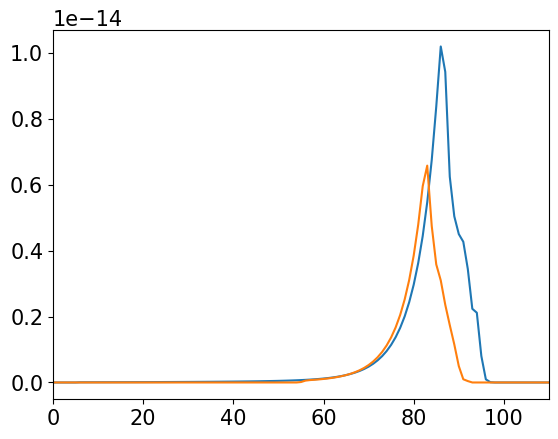

In [10]:
plt.plot(ref_signals[ref_id].flat);
plt.plot(wfs[jax_id].flatten());
plt.xlim(0, 110)

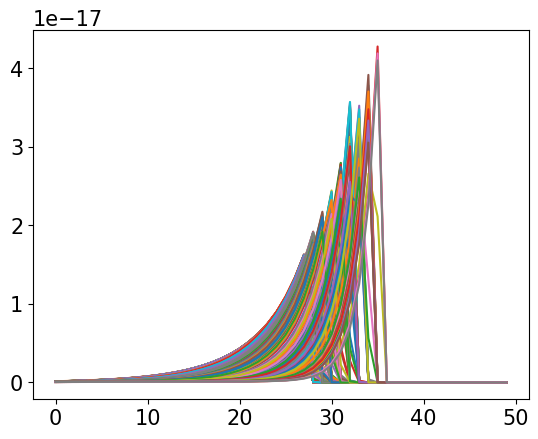

In [19]:
# plt.plot(jnp.sum(signals[pix_renumbering == 37], axis=0).T);
plt.plot(signals[pix_renumbering == 37].T);

(array([  1.,   0., 131.,   0.,   0., 415.,   0.,  90.,   0.,   1.]),
 array([54. , 54.4, 54.8, 55.2, 55.6, 56. , 56.4, 56.8, 57.2, 57.6, 58. ]),
 <BarContainer object of 10 artists>)

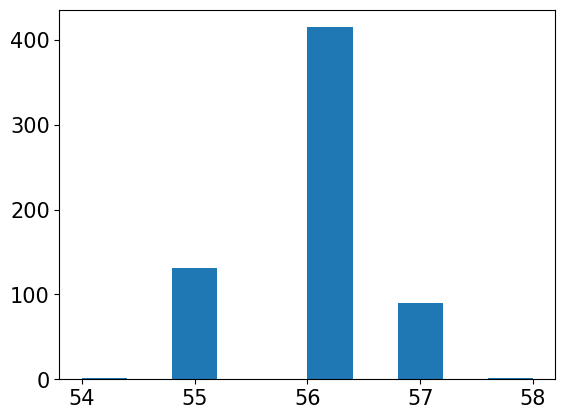

In [16]:
plt.hist(start_ticks[pix_renumbering == 37])

In [49]:
from flax import traverse_util
# jax.tree_util.tree_structure(norm_params)
norm_params.iterate_clz()

AttributeError: 'Params' object has no attribute 'iterate_clz'

In [3]:
#Running some fit

to_propagate = ("Ab", "kb", "lifetime")
history = []

niter = 500

modified_params = {
    'Ab': 0.5,
    'kb': 0.0786,
    "lifetime": 5e3,
    # "tran_diff": ref_params.tran_diff*1.1,
    # "long_diff": ref_params.long_diff*0.9
    # "tran_diff": 6e-6
}

lr = {
    'Ab': 1e-2,
    'lifetime': 1e-2,
    'kb': 1e-2
}

def extract_relevant_params(params, relevant):
    return {par: getattr(params, par) for par in relevant}

def update_params(params, update):
    return params.replace(**{key: getattr(params, key) + val for key, val in update.items()})



params = ref_params.replace(**modified_params)
# lr = 1e-2

params_normalization = params.replace()

norm_params = params.replace(**{key: 1. for key in to_propagate})

optimizer = optax.multi_transform({key: optax.adam(value) for key, value in lr.items()},
                                  {key: key for key in to_propagate})

opt_state = optimizer.init(extract_relevant_params(norm_params, to_propagate))

# optimizer = optax.adam(lr)
# opt_state = optimizer.init(norm_params)

# with jax.profiler.trace("/tmp/tensorboard"):
for i in tqdm(range(niter)):
    history.append(params)
    # for p in to_propagate:
    #     print(getattr(params, p))
    # value = params_loss(params, ref, pixels_ref, ticks_ref, tracks, fields)
    # print("Loss is:", value)
    # grads = grad(params_loss, (0))(params, ref, pixels_ref, ticks_ref, tracks, fields)
    loss_val, grads = value_and_grad(params_loss, (0))(params, ref, pixels_ref, ticks_ref, tracks, fields)
    # print(value)
    # print(grads.Ab, grads.kb, grads.lifetime)
    updates, opt_state = optimizer.update(extract_relevant_params(grads, to_propagate), opt_state)
    norm_params = update_params(norm_params, updates)
    # norm_params = optax.apply_updates(norm_params, updates)
    params = norm_params.replace(**{key: getattr(norm_params, key)*getattr(params_normalization, key) for key in to_propagate})
    # max_radius = get_max_radius(params)
    # if max_radius != params.max_radius:
    #     params = params.replace(max_radius=max_radius)
    #     neighbors_sp = get_neighboring_pixels_sp(params, active_pixels_sp)
flat_history = {}
for key in to_propagate:
    flat_history[key] = [getattr(par, key) for par in history]
#Compute the max radius at the beginning from all the tracks
#Eventually adapt it some parameters change by more than ...

  0%|          | 1/500 [00:03<30:57,  3.72s/it]

-215143.62 239699.94 -0.6503666


  0%|          | 2/500 [00:06<27:18,  3.29s/it]

-212502.27 239839.66 -0.63757086


  1%|          | 3/500 [00:07<16:26,  1.99s/it]

-207011.5 236378.1 -0.61508983


  1%|          | 4/500 [00:07<11:22,  1.38s/it]

-203193.1 234868.69 -0.59883523


  1%|          | 5/500 [00:08<08:31,  1.03s/it]

-198337.03 231892.22 -0.57899696


  1%|          | 6/500 [00:08<06:46,  1.21it/s]

-194492.0 230026.66 -0.5626122


  1%|▏         | 7/500 [00:08<05:40,  1.45it/s]

-189326.34 226461.58 -0.5427488


  2%|▏         | 8/500 [00:09<04:57,  1.66it/s]

-184728.75 223431.0 -0.5247999


  2%|▏         | 9/500 [00:09<04:29,  1.82it/s]

-190397.05 232601.44 -0.53389746


  2%|▏         | 10/500 [00:10<04:08,  1.97it/s]

-183989.4 227278.53 -0.51174504


  2%|▏         | 11/500 [00:10<03:56,  2.07it/s]

-177972.4 222265.11 -0.4909873


  2%|▏         | 12/500 [00:10<03:47,  2.14it/s]

-173103.2 218516.19 -0.47354183


  3%|▎         | 13/500 [00:11<03:48,  2.14it/s]

-167181.34 213322.19 -0.4538138


  3%|▎         | 14/500 [00:11<03:40,  2.20it/s]

-162783.53 209893.56 -0.43825775


  3%|▎         | 15/500 [00:12<03:37,  2.23it/s]

-127856.31 166835.08 -0.3411693


  3%|▎         | 16/500 [00:12<03:31,  2.29it/s]

-140211.31 184624.47 -0.37148187


  3%|▎         | 17/500 [00:13<03:30,  2.29it/s]

-113628.33 149307.47 -0.2947147


  4%|▎         | 18/500 [00:13<03:30,  2.29it/s]

-139775.25 187181.94 -0.36412495


  4%|▍         | 19/500 [00:14<03:28,  2.30it/s]

-141637.25 191783.62 -0.36703375


  4%|▍         | 20/500 [00:14<03:32,  2.25it/s]

-137490.75 187915.95 -0.35382116


  4%|▍         | 21/500 [00:14<03:28,  2.29it/s]

-135598.42 187158.88 -0.34676552


  4%|▍         | 22/500 [00:15<03:27,  2.31it/s]

-131572.81 183266.69 -0.3341622


  5%|▍         | 23/500 [00:15<03:25,  2.32it/s]

-127404.42 179070.4 -0.3214069


  5%|▍         | 24/500 [00:16<03:25,  2.32it/s]

-124098.19 176011.8 -0.311074


  5%|▌         | 25/500 [00:16<03:24,  2.32it/s]

-82426.47 118328.234 -0.20715208


  5%|▌         | 26/500 [00:17<03:24,  2.32it/s]

-115710.11 166974.56 -0.28644025


  5%|▌         | 27/500 [00:17<03:22,  2.34it/s]

-111534.55 162312.31 -0.27449322


  6%|▌         | 28/500 [00:17<03:19,  2.36it/s]

-109546.72 160720.88 -0.26793146


  6%|▌         | 29/500 [00:18<03:21,  2.34it/s]

-106153.09 157027.33 -0.2581557


  6%|▌         | 30/500 [00:18<03:20,  2.34it/s]

-102402.64 152701.83 -0.24765691


  6%|▌         | 31/500 [00:19<03:20,  2.34it/s]

-98977.81 148762.25 -0.23806384


  6%|▋         | 32/500 [00:19<03:19,  2.34it/s]

-95268.31 144304.03 -0.22792675


  7%|▋         | 33/500 [00:19<03:16,  2.38it/s]

-91598.11 139807.67 -0.21801496


  7%|▋         | 34/500 [00:20<03:18,  2.34it/s]

-87970.69 135280.16 -0.20832926


  7%|▋         | 35/500 [00:20<03:18,  2.34it/s]

-84436.17 130801.625 -0.1989824


  7%|▋         | 36/500 [00:21<03:20,  2.31it/s]

-81066.28 126490.03 -0.19014427


  7%|▋         | 37/500 [00:21<03:18,  2.33it/s]

-77628.77 121981.19 -0.18124232


  8%|▊         | 38/500 [00:22<03:20,  2.31it/s]

-74281.016 117520.71 -0.17264718


  8%|▊         | 39/500 [00:22<03:19,  2.31it/s]

-71057.19 113174.875 -0.16443512


  8%|▊         | 40/500 [00:23<03:22,  2.27it/s]

-67851.52 108783.14 -0.15636513


  8%|▊         | 41/500 [00:23<03:22,  2.27it/s]

-64757.656 104483.53 -0.14861551


  8%|▊         | 42/500 [00:23<03:21,  2.27it/s]

-61611.832 100027.734 -0.14084038


  9%|▊         | 43/500 [00:24<03:20,  2.27it/s]

-58558.508 95642.97 -0.13334821


  9%|▉         | 44/500 [00:24<03:17,  2.30it/s]

-55562.844 91284.83 -0.12606165


  9%|▉         | 45/500 [00:25<03:16,  2.31it/s]

-52741.023 87144.305 -0.119244084


  9%|▉         | 46/500 [00:25<03:14,  2.33it/s]

-49859.305 82838.48 -0.11234181


  9%|▉         | 47/500 [00:26<03:16,  2.30it/s]

-47099.605 78673.81 -0.10577597


 10%|▉         | 48/500 [00:26<03:13,  2.33it/s]

-44462.49 74648.164 -0.09952396


 10%|▉         | 49/500 [00:26<03:14,  2.32it/s]

-34713.945 59714.414 -0.07856632


 10%|█         | 50/500 [00:27<03:15,  2.30it/s]

-37493.742 63854.312 -0.083699174


 10%|█         | 51/500 [00:27<03:14,  2.31it/s]

-34387.273 58956.98 -0.076662436


 10%|█         | 52/500 [00:28<03:14,  2.30it/s]

-35009.332 59788.96 -0.07736416


 11%|█         | 53/500 [00:28<03:14,  2.30it/s]

86252.48 -156129.19 0.20777938


 11%|█         | 54/500 [00:29<03:15,  2.28it/s]

-802.37305 -638.7949 0.0026196614


 11%|█         | 55/500 [00:29<03:14,  2.29it/s]

1182.5537 -4068.4805 0.007003501


 11%|█         | 56/500 [00:30<03:14,  2.28it/s]

-23085.404 39512.156 -0.049791344


 11%|█▏        | 57/500 [00:30<03:12,  2.30it/s]

-21522.389 36899.477 -0.04628309


 12%|█▏        | 58/500 [00:30<03:10,  2.32it/s]

-20002.178 34344.836 -0.042880975


 12%|█▏        | 59/500 [00:31<03:09,  2.33it/s]

-21535.387 37310.92 -0.046604715


 12%|█▏        | 60/500 [00:31<03:09,  2.33it/s]

-20112.883 34911.07 -0.043430965


 12%|█▏        | 61/500 [00:32<03:10,  2.30it/s]

-18737.084 32579.773 -0.040368833


 12%|█▏        | 62/500 [00:32<03:11,  2.29it/s]

-17486.367 30454.02 -0.03758233


 13%|█▎        | 63/500 [00:33<03:11,  2.28it/s]

-16172.298 28205.89 -0.034672704


 13%|█▎        | 64/500 [00:33<03:10,  2.29it/s]

-15173.696 26464.227 -0.0324231


 13%|█▎        | 65/500 [00:33<03:07,  2.32it/s]

-13963.521 24374.18 -0.029751323


 13%|█▎        | 66/500 [00:34<03:10,  2.28it/s]

-12796.3545 22350.088 -0.027179847


 13%|█▎        | 67/500 [00:34<03:10,  2.27it/s]

-11673.732 20395.562 -0.024711441


 14%|█▎        | 68/500 [00:35<03:10,  2.26it/s]

-13579.416 24026.531 -0.029229796


 14%|█▍        | 69/500 [00:35<03:10,  2.26it/s]

-12548.643 22229.877 -0.026967715


 14%|█▍        | 70/500 [00:36<03:13,  2.22it/s]

-11719.979 20795.332 -0.025154695


 14%|█▍        | 71/500 [00:36<03:14,  2.21it/s]

-10754.496 19101.277 -0.023042923


 14%|█▍        | 72/500 [00:37<03:17,  2.16it/s]

-9828.817 17470.975 -0.021020548


 15%|█▍        | 73/500 [00:37<03:15,  2.19it/s]

-8933.776 15890.361 -0.019068878


 15%|█▍        | 74/500 [00:38<03:15,  2.18it/s]

-8202.326 14606.896 -0.017482119


 15%|█▌        | 75/500 [00:38<03:14,  2.19it/s]

-7389.7686 13163.885 -0.015714588


 15%|█▌        | 76/500 [00:38<03:14,  2.18it/s]

-6634.3843 11821.164 -0.014074177


 15%|█▌        | 77/500 [00:39<03:12,  2.20it/s]

-5960.848 10624.984 -0.012621179


 16%|█▌        | 78/500 [00:39<03:10,  2.21it/s]

-5301.5234 9437.396 -0.011186432


 16%|█▌        | 79/500 [00:40<03:12,  2.19it/s]

-4714.066 8383.863 -0.009911481


 16%|█▌        | 80/500 [00:40<03:08,  2.23it/s]

-4081.7327 7247.2344 -0.008544033


 16%|█▌        | 81/500 [00:41<03:08,  2.22it/s]

-3530.4485 6254.7334 -0.0073551796


 16%|█▋        | 82/500 [00:41<03:06,  2.24it/s]

-2971.4758 5245.9595 -0.00614857


 17%|█▋        | 83/500 [00:42<03:05,  2.25it/s]

-2529.105 4452.4863 -0.005206477


 17%|█▋        | 84/500 [00:42<03:03,  2.26it/s]

-2034.1581 3555.6687 -0.0041390313


 17%|█▋        | 85/500 [00:42<03:01,  2.28it/s]

-1580.6582 2733.1196 -0.0031623207


 17%|█▋        | 86/500 [00:43<03:03,  2.26it/s]

-1296.2444 2193.0503 -0.00252893


 17%|█▋        | 87/500 [00:43<03:01,  2.27it/s]

-1298.0559 2224.0938 -0.0025839345


 18%|█▊        | 88/500 [00:44<03:04,  2.24it/s]

-944.13855 1579.6088 -0.0018224033


 18%|█▊        | 89/500 [00:44<03:03,  2.24it/s]

-618.3358 985.62683 -0.0011217252


 18%|█▊        | 90/500 [00:45<03:03,  2.24it/s]

-319.81793 440.81927 -0.00048003468


 18%|█▊        | 91/500 [00:45<03:02,  2.25it/s]

-49.4075 -53.200317 0.000101006066


 18%|█▊        | 92/500 [00:46<03:00,  2.26it/s]

197.11649 -503.9493 0.00063050946


 19%|█▊        | 93/500 [00:46<03:05,  2.19it/s]

418.92358 -909.82513 0.0011067555


 19%|█▉        | 94/500 [00:46<03:04,  2.20it/s]

617.12946 -1272.7732 0.0015321984


 19%|█▉        | 95/500 [00:47<03:04,  2.19it/s]

792.7584 -1594.5845 0.0019090823


 19%|█▉        | 96/500 [00:47<03:06,  2.16it/s]

946.9249 -1877.229 0.002239838


In [11]:
loss_val

Array(0.2592362, dtype=float32)

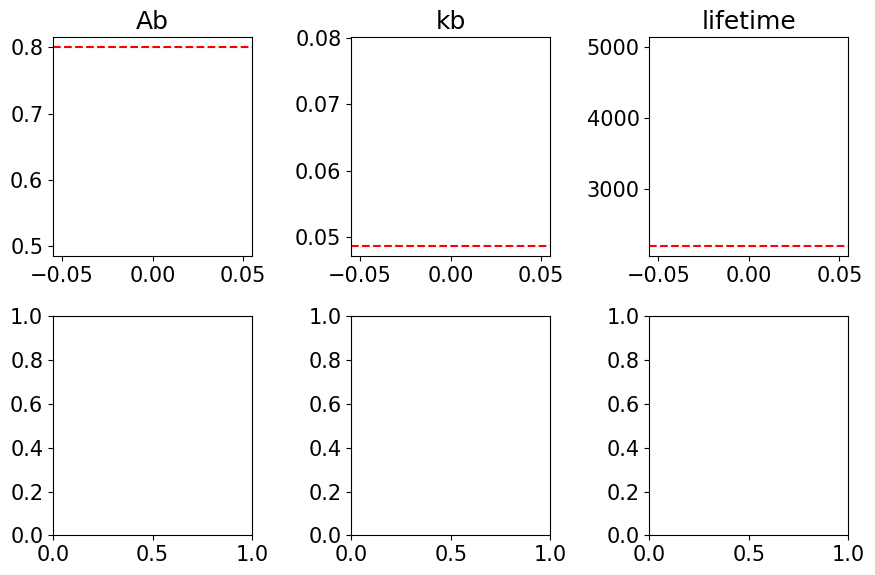

In [13]:
#Plotting of the fits
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for it, key in enumerate(to_propagate):
    i = it//ncols
    j = it%ncols

    ax = axs[i, j]
    ax.plot(flat_history[key])
    ax.axhline(getattr(ref_params, key), linestyle='dashed', color='red')
    ax.set_title(key)
fig.tight_layout()

# Debugging

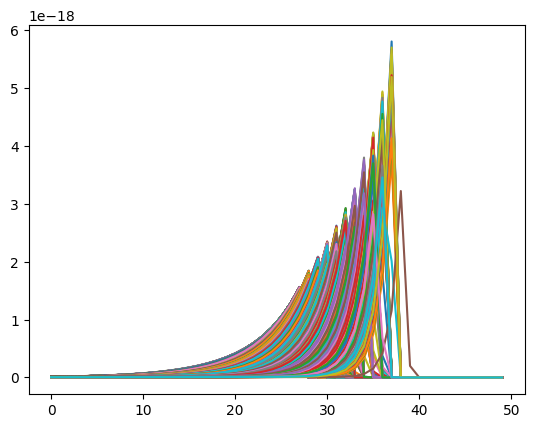

In [4]:
plt.plot(signals[pix_renumbering == 1].T);


(50.0, 150.0)

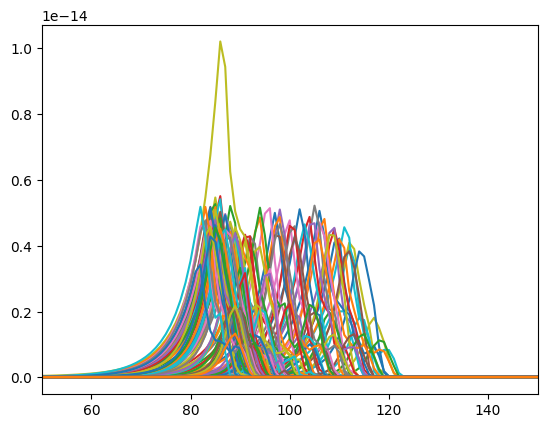

In [5]:
plt.plot(ref_signals.T);
plt.xlim(50, 150)

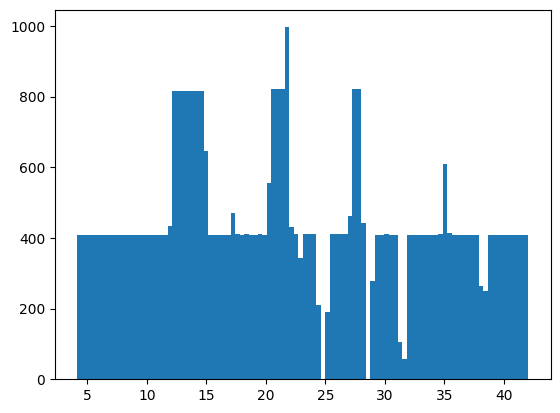

In [7]:
plt.hist(tracks[:, fields.index("y")], bins=100);

In [37]:
from larndsim.fee_jax import get_adc_values
# Testing the digitization
signal = np.arange(0, 1000)
signal[signal < 100] = 0
signal[signal > 900] = 0
signal[signal > 0] = 1

signal = jnp.array(signal)
signal = signal.reshape((1, 1000))

integral, ticks = get_adc_values(ref_params, signal)

print(integral)

[[80.100006  0.        0.        0.        0.        0.        0.
   0.        0.        0.      ]]


In [2]:
ref_params = load_params()

In [19]:
ref_params.meta_fields

AttributeError: 'Params' object has no attribute 'meta_fields'

209.0


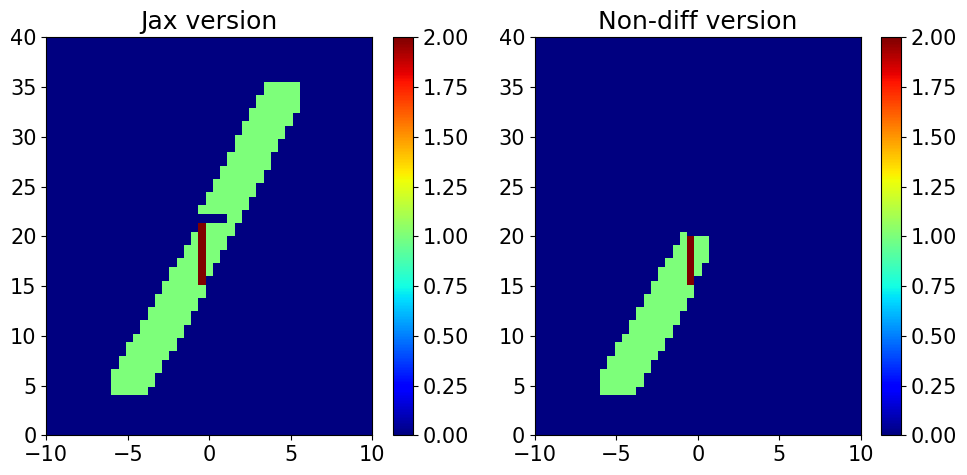

<Figure size 640x480 with 0 Axes>

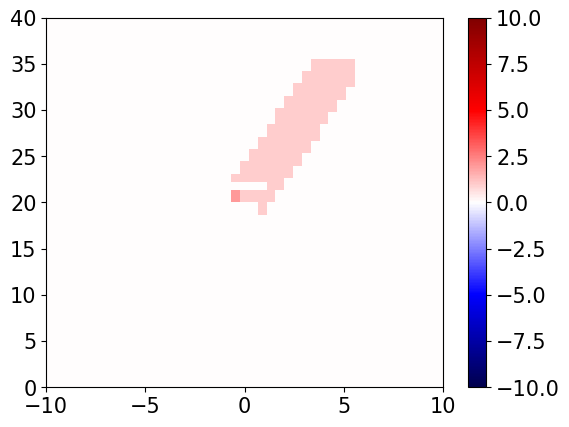

In [4]:
def load_ref_results(fname):
    # fname = "/home/pgranger/larnd-sim/tools/evd/data/result_legacy_nonoise.h5"
    with h5py.File(fname, 'r') as f:
        pixels = np.array(f['pixels'])
        adc = np.array(f['adc'])
        signals = np.array(f['signals'])
    return pixels, signals, adc

fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_output_lifetime.h5"
ref_pixels, ref_signals, ref_adc = load_ref_results(fname)
ref_coords = get_pixel_coordinates(ref_params, ref_pixels[:, 0], ref_pixels[:, 1], np.zeros(ref_adc.shape[0]))

fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_split_output_lifetime.h5"
pixels_ref, ref_signals, ref = load_ref_results(fname)
coords = get_pixel_coordinates(ref_params, pixels_ref[:, 0], pixels_ref[:, 1], np.zeros(pixels_ref.shape[0]))

# fname = "/home/pgranger/larnd-sim/jit_version/original/single_track_chopped_100_output_lifetime.h5"
# ref_pixels, ref_signals, ref_adc = load_ref_results(fname)
# xpitch, ypitch, plane, eid = id2pixel(ref_params, ref_pixels)
# ref_coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(ref_adc.shape[0]))

# fname = "/home/pgranger/larnd-sim/jit_version/original/single_track_chopped_0.1_output_lifetime.h5"
# pixels_ref, ref_signals, ref = load_ref_results(fname)
# xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
# coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(pixels_ref.shape[0]))

# xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
# pixels_coord = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)

xbins = np.linspace(ref_params.tpc_borders[0][0][0], ref_params.tpc_borders[0][0][1], ref_params.n_pixels[0] + 1)
ybins = np.linspace(ref_params.tpc_borders[0][1][0], ref_params.tpc_borders[0][1][1], ref_params.n_pixels[1] + 1)

xbins = np.linspace(-10, 10, int(np.ceil(20./ref_params.pixel_pitch)))
ybins = np.linspace(0, 40, int(np.ceil(40./ref_params.pixel_pitch)))
vmin = 0
vmax = 30

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

h1, _, _, im = axs[0].hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet');
# h1, _, _, im = axs[0].hist2d(coords[:, 0], coords[:, 1], weights=np.sum(ref, axis=1)-10*np.min(ref), bins=(xbins, ybins), cmap='jet', vmin=vmin, vmax=vmax);
# jax_bins, _, _, _ = plt.hist2d(pixels_coord[:, 0], pixels_coord[:, 1], weights=np.max(ref, axis=1), bins=(xbins, ybins));
# plt.hist2d(ref[:, fields.index("x")], ref[:, fields.index("y")], weights=ref[:, fields.index("n_electrons")], bins=(xbins, ybins));
fig.colorbar(im, ax=axs[0])
# plt.figure()
# # plt.hist2d(xpitch[plane == 0], ypitch[plane == 0], bins=(ref_params.n_pixels[0], ref_params.n_pixels[1]));
plt.figure()
# # plt.hist2d(xpitch[plane == 1], ypitch[plane == 1], bins=(ref_params.n_pixels[0], ref_params.n_pixels[1]));
# plt.hist2d(tracks[:, fields.index('x')], tracks[:, fields.index('y')], bins=(xbins, ybins));
# plt.hist2d(ref_pixels[:, 0]*ref_params.pixel_pitch + ref_params.tpc_borders[0][0][0], ref_pixels[:, 1]*ref_params.pixel_pitch + ref_params.tpc_borders[0][1][0], weights=ref_adc[:, 0], bins=(xbins, ybins));
h2, xedges, yedges, im2 = axs[1].hist2d(ref_coords[:, 0], ref_coords[:, 1], bins=(xbins, ybins), cmap='jet');
# h2, xedges, yedges, im2 = axs[1].hist2d(ref_coords[:, 0], ref_coords[:, 1], weights=np.sum(ref_adc, axis=1)-740, bins=(xbins, ybins), cmap='jet', vmin=vmin, vmax=vmax);
# ref_bins, _, _, _ = plt.hist2d(ref_coords[:, 0], ref_coords[:, 1], weights=np.max(ref_signals, axis=1), bins=(xbins, ybins));
fig.colorbar(im2, ax=axs[1])

axs[0].set_title('Jax version')
axs[1].set_title('Non-diff version')

fig.tight_layout()
fig.savefig('')

# plt.figure()
# plt.hist2d(tracks[:, fields.index('x')], tracks[:, fields.index('y')], weights=tracks[:, fields.index('dE')], bins=(xbins, ybins), norm='log');
# plt.colorbar()

# plt.figure()
# plt.hist2d(original_tracks[:, fields.index('x_end')], original_tracks[:, fields.index('y_end')], weights=original_tracks[:, fields.index('dE')], bins=(xbins, ybins));
# plt.colorbar()
plt.figure()
plt.pcolormesh(xedges, yedges, (h1 - h2).T, cmap='seismic', vmin=-10, vmax=10);
plt.colorbar()
print(np.sum((h1 - h2)))

In [16]:
print(np.sum(np.sum(ref, axis=1)-10*np.min(ref)))
print(np.sum(np.sum(ref_adc, axis=1)-740))

2303.1665
2540.0


In [5]:
%timeit simulate(params, tracks, fields)

3.61 ms ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
make_jaxpr(tracks_current)(ref_params, pixels)

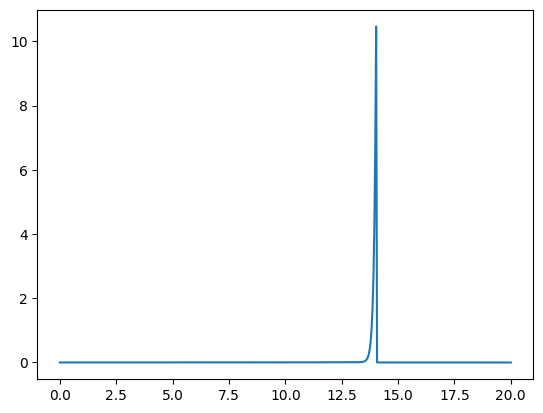

In [19]:
from larndsim.detsim_jax import current_model

t0 = 10
x = 0.4434/2
y = 0.4434/2
t = jnp.linspace(0, 20, 500)

current = current_model(t, t0, x, y)

plt.plot(t, current)

In [55]:
ref_params.tpc_borders

Array([[[-31.039  ,  31.039  ],
        [-83.8626 ,  40.2154 ],
        [-30.431  ,  -0.15875]],

       [[-31.039  ,  31.039  ],
        [-83.8626 ,  40.2154 ],
        [ 30.431  ,   0.15875]]], dtype=float32)

In [21]:
from jax.experimental.sparse import BCOO
import jax.numpy as jnp

size = 100000000000000

data = jnp.array([1., 3., 5.])
indices = jnp.array([[0],
                     [1],
                     [2]])
indices2 = jnp.array([[size - 10],
                     [size - 5000],
                     [size - 10000]])
mat = BCOO((data, indices), shape=(size,))
mat2 = BCOO((data, indices2), shape=(size,))
mat.update_layout()

BCOO(float32[100000000000000], nse=6)

In [22]:
tracks_file = '/home/pgranger/larnd-sim/tools/evd/data/single_track.h5'
tracks, fields, original_tracks = prepare_tracks(ref_params, tracks_file)

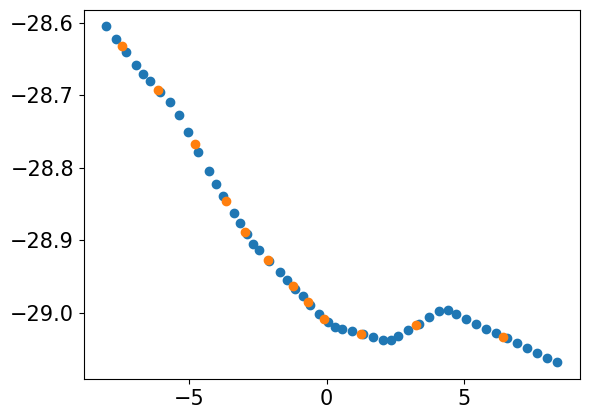

In [38]:
plt.scatter(tracks[:, fields.index('x')], tracks[:, fields.index('z')])
plt.scatter(original_tracks[:, fields.index('x')], original_tracks[:, fields.index('z')])

In [29]:
print(np.sum(original_tracks[:, fields.index('dE')]), np.sum(tracks[:, fields.index('dE')]))

82.71936 82.71936


In [6]:
print(original_tracks[:, fields.index("dE")])
print(tracks[:, fields.index("dE")])

[21.705599  10.616191   9.545288   3.4940083  2.457487   2.8358514
  5.075712   2.3741586  4.709486   6.9369493  6.403756   6.5648756]
[21.705599  10.616191   9.545288   3.4940083  2.457487   2.8358514
  5.075712   2.3741586  4.709486   6.9369493  6.403756   6.5648756]


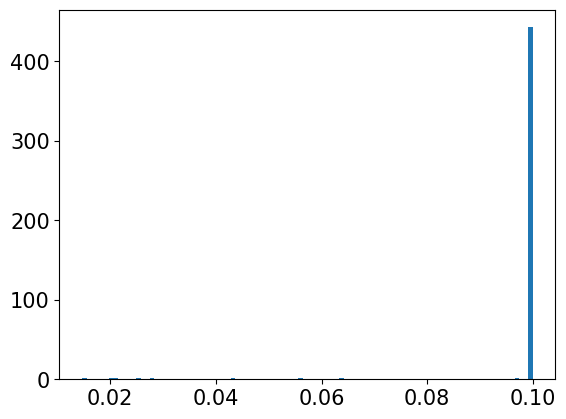

In [7]:
start = np.stack([tracks[:, fields.index("x_start")],
                        tracks[:, fields.index("y_start")],
                        tracks[:, fields.index("z_start")]], axis=1)
end = np.stack([tracks[:, fields.index("x_end")],
                tracks[:, fields.index("y_end")],
                tracks[:, fields.index("z_end")]], axis=1)

segment = end - start
length = np.sqrt(np.sum(segment**2, axis=1, keepdims=True))

plt.hist(length, bins=100);

In [52]:
with h5py.File("./single_track_chopped_100.h5", 'r') as f:
    segA = np.array(f['segments'])
with h5py.File("./single_track.h5", 'r') as f:
    segB = np.array(f['segments'])

for col in segA.dtype.names:
    print(col, segA[:][col])

eventID [3 3 3 3 3 3 3 3 3 3 3 3]
z_end [ 4.289143    2.2631059   0.25312302 -0.4116568  -0.94118005 -1.5175517
 -2.7214005  -3.1906717  -4.104757   -5.510226   -6.7399793  -8.194712  ]
trackID [2 2 2 2 2 2 2 2 2 2 2 2]
tran_diff [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
z_start [ 8.587764    4.289143    2.2631059   0.25312302 -0.4116568  -0.94118005
 -1.5175517  -2.7214005  -3.1906717  -4.104757   -5.510226   -6.7399793 ]
x_end [-28.99409  -29.039394 -29.018919 -28.997208 -28.9746   -28.951233
 -28.904457 -28.873878 -28.818243 -28.71764  -28.668282 -28.59709 ]
y_end [ 9.56767   14.6032505 19.523972  21.10437   22.361298  23.7425
 26.659643  27.785797  30.033998  33.501545  36.585747  40.2307   ]
n_electrons [0 0 0 0 0 0 0 0 0 0 0 0]
pdgId [13 13 13 13 13 13 13 13 13 13 13 13]
x_start [-29.07201  -28.99409  -29.039394 -29.018919 -28.997208 -28.9746
 -28.951233 -28.904457 -28.873878 -28.818243 -28.71764  -28.668282]
y_start [-1.2663448  9.56767   14.6032505 19.523972  21.10437   22.361298
 

In [17]:
#Building a basic example

def get_length(track):
    return np.sqrt(
        (track['x_start'] - track['x_end'])**2 + 
        (track['y_start'] - track['y_end'])**2 + 
        (track['z_start'] - track['z_end'])**2
    ) 

def single_track(tracks):
    track = tracks[:1].copy()

    #Drift direction
    track[0]['x_start'] = -12.01
    track[0]['x_end'] = -11.99
    track[0]['x'] = -12

    track[0]['z_start'] = -5
    track[0]['z_end'] = 5
    track[0]['z'] = 0

    track[0]['y_start'] = 5
    track[0]['y_end'] = 35
    track[0]['y'] = 20

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 2
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']

    return track

def single_track_nodz(tracks):
    track = tracks[:1].copy()

    #Drift direction
    track[0]['x_start'] = 12
    track[0]['x_end'] = 12
    track[0]['x'] = 12

    track[0]['z_start'] = -5
    track[0]['z_end'] = 5
    track[0]['z'] = 0

    track[0]['y_start'] = 5
    track[0]['y_end'] = 35
    track[0]['y'] = 20

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 2
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']

    return track

def double_track(tracks):
    track = tracks[:2].copy()

    #Drift direction
    track[0]['x_start'] = 12.01
    track[0]['x_end'] = 12
    track[0]['x'] = 12.005

    track[0]['z_start'] = -5
    track[0]['z_end'] = 0
    track[0]['z'] = -2.5

    track[0]['y_start'] = 5
    track[0]['y_end'] = 20
    track[0]['y'] = 12.5

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 2
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']

    #Drift direction
    track[1]['x_start'] = 12
    track[1]['x_end'] = 11.99
    track[1]['x'] = 11.995

    track[1]['z_start'] = 0
    track[1]['z_end'] = 5
    track[1]['z'] = 2.5

    track[1]['y_start'] = 20
    track[1]['y_end'] = 35
    track[1]['y'] = 27.5

    track[1]['dx'] = get_length(track[1])
    track[1]['dEdx'] = 2
    track[1]['dE'] = track[1]['dx']*track[1]['dEdx']

    return track

with h5py.File("./single_track.h5", 'r') as f:
    tracks = np.array(f['segments'])

track_single = single_track(tracks)

with h5py.File("./simplified_single_track.h5", 'w') as f:
    f.create_dataset('segments', data=track_single)

track_single_nodz = single_track_nodz(tracks)

with h5py.File("./simplified_single_track_nodz.h5", 'w') as f:
    f.create_dataset('segments', data=track_single_nodz)

track_double = double_track(tracks)

with h5py.File("./simplified_single_track_split.h5", 'w') as f:
    f.create_dataset('segments', data=track_double)

print(track_double)

import pandas as pd
from IPython.display import display, HTML

print(track_double.dtype.names)

selected_fields = ['x', 'x_start', 'x_end', 'y', 'y_start', 'y_end', 'z', 'z_start', 'z_end', 'dE', 'dx', 'dEdx']

with h5py.File("./simplified_single_track_split.h5", 'r') as f:
    display(pd.DataFrame(np.array(f['segments']))[selected_fields])

[(3,  4.289143  , 2, 0.,  8.587764  , -28.99409 ,  9.56767  , 0, 13, -29.07201 , -1.2663448, 0., 0.00084798, 0.00123894, 0.00104346, 11.655904 , 0., 0, 0., 1.8621979, 21.705599 , 0.,  4.1506624, -29.03305 ,  6.4384537 , 0.)
 (3,  2.2631059 , 2, 0.,  4.289143  , -29.039394, 14.6032505, 0, 13, -28.99409 ,  9.56767  , 0., 0.00123894, 0.00142106, 0.00133   ,  5.4280705, 0., 0, 0., 1.9557945, 10.616191 , 0., 12.085461 , -29.016743,  3.2761245 , 0.)
 (3,  0.25312302, 2, 0.,  2.2631059 , -29.018919, 19.523972 , 0, 13, -29.039394, 14.6032505, 0., 0.00142106, 0.00159945, 0.00151025,  5.315444 , 0., 0, 0., 1.7957649,  9.545288 , 0., 17.06361  , -29.029156,  1.2581145 , 0.)
 (3, -0.4116568 , 2, 0.,  0.25312302, -28.997208, 21.10437  , 0, 13, -29.018919, 19.523972 , 0., 0.00159945, 0.001657  , 0.00162822,  1.7146612, 0., 0, 0., 2.0377252,  3.4940083, 0., 20.31417  , -29.008064, -0.07926689, 0.)
 (3, -0.94118005, 2, 0., -0.4116568 , -28.9746  , 22.361298 , 0, 13, -28.997208, 21.10437  , 0., 0.00165

,x,x_start,x_end,y,y_start,y_end,z,z_start,z_end,dE,dx,dEdx
0,12.005,12.01,12.00,12.5,5.0,20.0,-2.5,-5.0,0.0,31.622784,15.811392,2.0
1,11.995,12.00,11.99,27.5,20.0,35.0,2.5,0.0,5.0,31.622784,15.811392,2.0


In [27]:
ref_params.tpc_borders

Array([[[-31.039  ,  31.039  ],
        [-83.8626 ,  40.2154 ],
        [-30.431  ,  -0.15875]],

       [[-31.039  ,  31.039  ],
        [-83.8626 ,  40.2154 ],
        [ 30.431  ,   0.15875]]], dtype=float32)

In [37]:
tracks, dtype = load_data('/home/pgranger/larnd-sim/tools/evd/data/single_track.h5')
fields = dtype.names
chopped = chop_tracks(tracks[:1], fields, 1)
for col in chopped.dtype.names:
    print(col)

TypeError: 'NoneType' object is not iterable

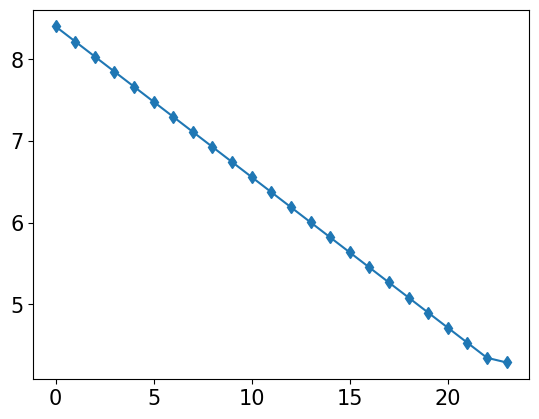

In [62]:
plt.plot(chopped[:, fields.index('x_end')], marker='d')

In [59]:
fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_output_lifetime.h5"
ref_pixels, ref_signals, ref_adc = load_ref_results(fname)
# ref_coords = get_pixel_coordinates(ref_params, ref_pixels[:, 0], ref_pixels[:, 1], np.zeros(ref_adc.shape[0]))

# fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_chopped_0.1_output_lifetime.h5"
# pixels_ref, ref_signals, ref = load_ref_results(fname)
# coords = get_pixel_coordinates(ref_params, pixels_ref[:, 0], pixels_ref[:, 1], np.zeros(pixels_ref.shape[0]))

# print(ref_pixels - pixels_ref)

np.count_nonzero(ref_adc-74)

0

In [16]:
fname = "/home/pgranger/larnd-sim/jit_version/original/single_track_chopped_100_output_lifetime.h5"
ref_pixels, ref_signals, ref_adc = load_ref_results(fname)
xpitch, ypitch, plane, eid = id2pixel(ref_params, ref_pixels)
ref_coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(ref_adc.shape[0]))

fname = "/home/pgranger/larnd-sim/jit_version/original/single_track_chopped_0.1_output_lifetime.h5"
pixels_ref, ref_signals, ref = load_ref_results(fname)
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(pixels_ref.shape[0]))

print(ref_pixels - pixels_ref)

[   0    0    0    1    1    1  137    1    1    1  137    2    2    2
  137  137    2    2    2  137    1    1    1  136    1    1    1    1
    0    0    0    0    1    1    1    1  136    1    1    1  137    1
    1    1  136    1    1    1    1    0    0    0    0    1    1    1
    1  136    1    1    1  137    1    1    1  136    1    1    1    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    1    1    1    1  136    1    1    1  137    1
    1    1  137    2    2    2  137    1    1    1  137    2    2    2
  138  138    3    3  138  138    2    2  138  138    3    3  138  138
    2    2    2  137    2    2    2  138  138    3    3  138  138    2
    2  138  138    3    3  138  138    2    2    2  137    2    2    2
  137  137    2    2    2  137    1    1    1  136    1    1    1    1
    0 

In [15]:
fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_chopped_100_output_lifetime.h5"
ref_pixels, ref_signals, ref_adc = load_ref_results(fname)
ref_coords = get_pixel_coordinates(ref_params, ref_pixels[:, 0], ref_pixels[:, 1], np.zeros(ref_adc.shape[0]))

fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_chopped_1_output_lifetime.h5"
pixels_ref, ref_signals, ref = load_ref_results(fname)
coords = get_pixel_coordinates(ref_params, pixels_ref[:, 0], pixels_ref[:, 1], np.zeros(pixels_ref.shape[0]))

Loaded a total of 441 pixels from file /home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_output_lifetime.h5
441 are unique
Loaded a total of 441 pixels from file /home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_nodz_output_lifetime.h5
441 are unique
Loaded a total of 434 pixels from file /home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_split_output_lifetime.h5
434 are unique
Loaded a total of 138 pixels from file /home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output.h5
138 are unique
Loaded a total of 138 pixels from file /home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output_nodz.h5
138 are unique
Loaded a total of 138 pixels from file /home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output_split.h5
138 are unique
[-7.  0.  1.  2.  3.]


(0.0, 40.0)

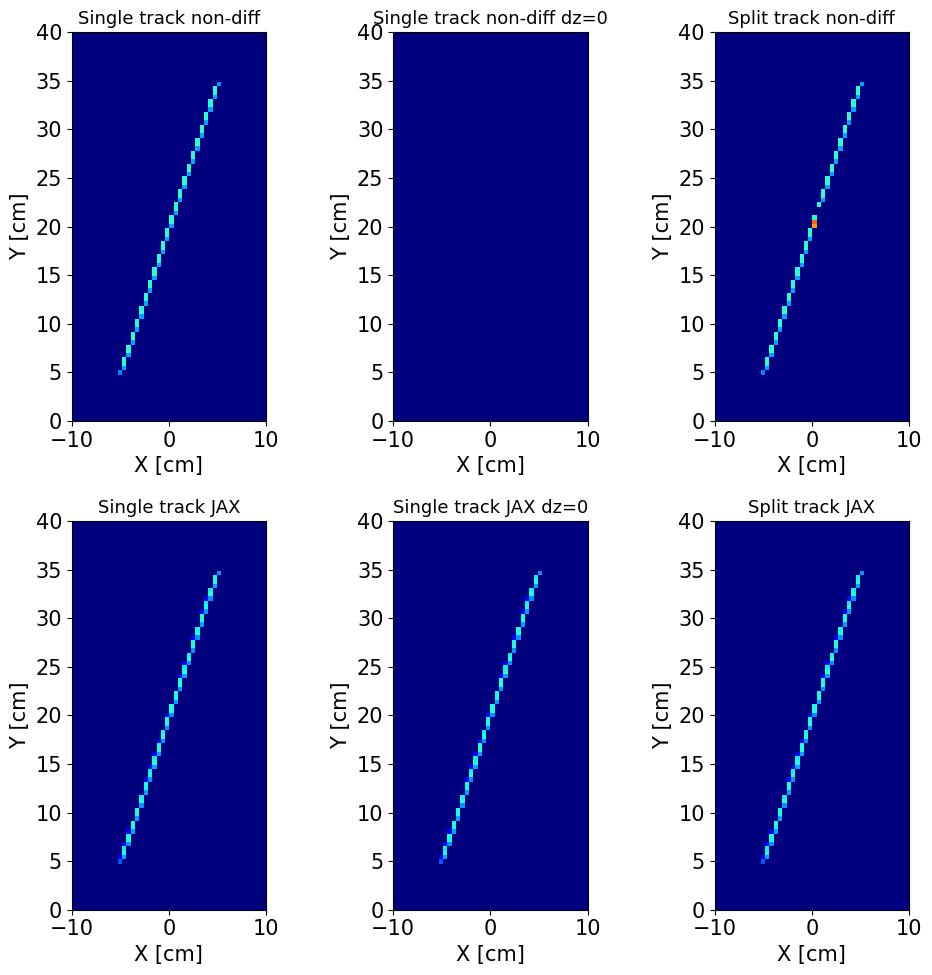

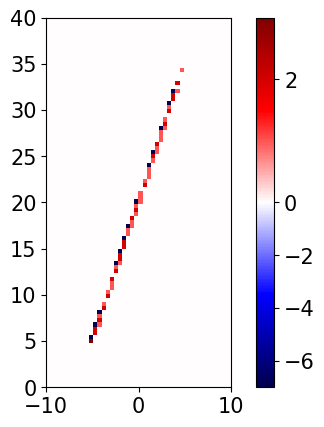

In [4]:
from evd import SimResult

def plot_jax(pixels, aprams):
    xpitch, ypitch, plane, eid = id2pixel(params, pixels)
    coords = get_pixel_coordinates(params, xpitch, ypitch, np.zeros(pixels.shape[0]))
    

fig, axs = plt.subplots(2, 3, figsize=(10, 10))

res = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_output_lifetime.h5", ref_params, title="Single track non-diff")
res2 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_nodz_output_lifetime.h5", ref_params, title="Single track non-diff dz=0")
res3 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_split_output_lifetime.h5", ref_params, title="Split track non-diff")

# res2 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output.h5", ref_params)
res4 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output.h5", ref_params, title="Single track JAX")
res5 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output_nodz.h5", ref_params, title="Single track JAX dz=0")
res6 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output_split.h5", ref_params, title="Split track JAX")

results = [res, res2, res3, res4, res5, res6]

for i, result in enumerate(results):
    r = i//3
    c = i%3
    ax = axs[r, c]
    result.plot_pixels(ax=ax, cbar=False)
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 40)
    ax.set_title(result.title, fontsize=13)

fig.tight_layout()

res.plot_diff(res4)
ax = plt.gca()
ax.set_xlim(-10, 10)
ax.set_ylim(0, 40)

Loaded a total of 282 pixels from file /home/pgranger/larnd-sim/jit_version/original/simplified_single_track_output_lifetime.h5
282 are unique
Loaded a total of 282 pixels from file /home/pgranger/larnd-sim/jit_version/original/simplified_single_track_nodz_output_lifetime.h5
282 are unique
Loaded a total of 282 pixels from file /home/pgranger/larnd-sim/jit_version/original/simplified_single_track_split_output_lifetime.h5
282 are unique
[-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.
   1.   2.   7.   8.]


(0.0, 40.0)

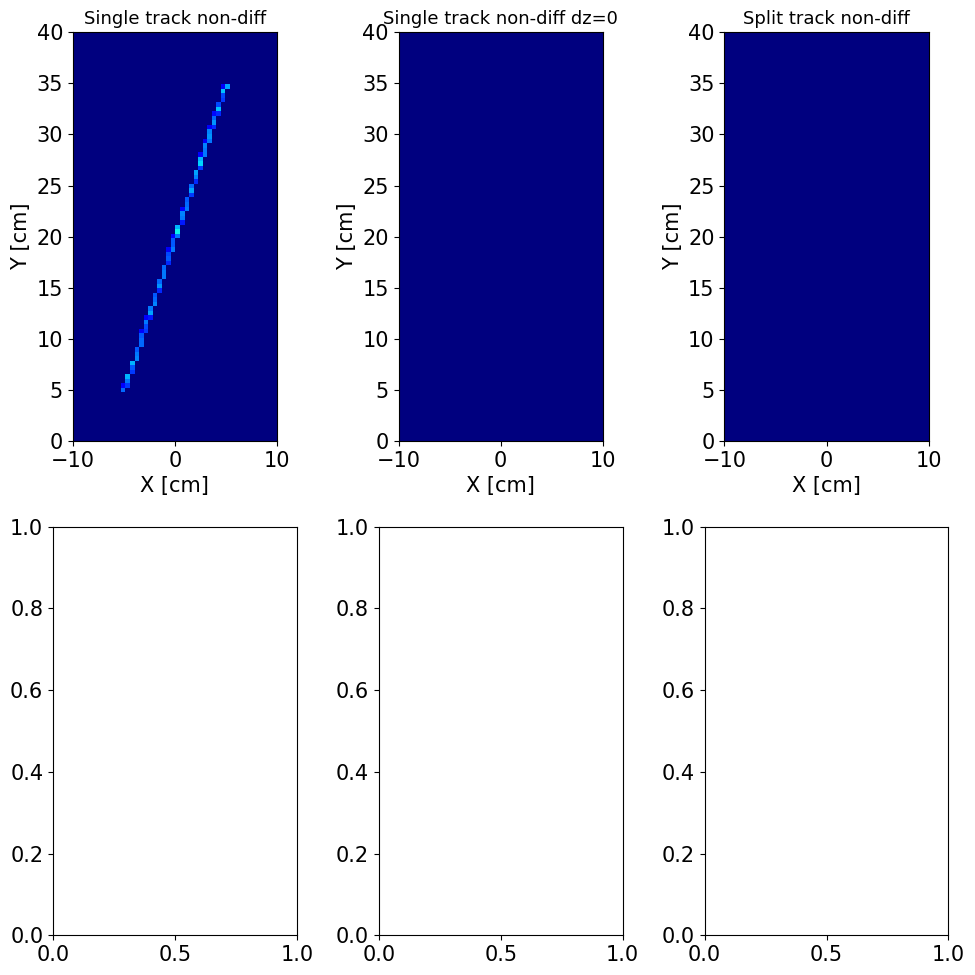

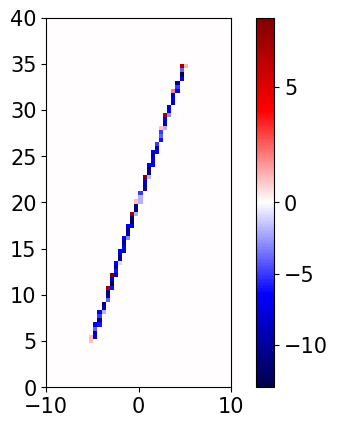

In [20]:
from evd import SimResult

def plot_jax(pixels, aprams):
    xpitch, ypitch, plane, eid = id2pixel(params, pixels)
    coords = get_pixel_coordinates(params, xpitch, ypitch, np.zeros(pixels.shape[0]))
    

fig, axs = plt.subplots(2, 3, figsize=(10, 10))

res = SimResult("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_output_lifetime.h5", ref_params, title="Single track non-diff")
res2 = SimResult("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_nodz_output_lifetime.h5", ref_params, title="Single track non-diff dz=0")
res3 = SimResult("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_split_output_lifetime.h5", ref_params, title="Split track non-diff")

# res2 = SimResult("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output.h5", ref_params)
# res4 = SimResult("/home/pgranger/larnd-sim/jit_version/original/jax_output.h5", ref_params, title="Single track JAX")
# res5 = SimResult("/home/pgranger/larnd-sim/jit_version/original/jax_output_nodz.h5", ref_params, title="Single track JAX dz=0")
# res6 = SimResult("/home/pgranger/larnd-sim/jit_version/original/jax_output_split.h5", ref_params, title="Split track JAX")

results = [res, res2, res3]

for i, result in enumerate(results):
    r = i//3
    c = i%3
    ax = axs[r, c]
    result.plot_pixels(ax=ax, cbar=False)
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 40)
    ax.set_title(result.title, fontsize=13)

fig.tight_layout()

res.plot_diff(res4)
ax = plt.gca()
ax.set_xlim(-10, 10)
ax.set_ylim(0, 40)

In [23]:
with h5py.File("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_split_output_lifetime.h5") as f:
    segments = np.array(f['segments'])
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame(segments)

,segment_id,eventID,z_end,trackID,tran_diff,z_start,x_end,y_end,n_electrons,pdgId,x_start,y_start,t_start,t0_start,t0_end,t0,dx,long_diff,pixel_plane,t_end,dEdx,dE,t,y,x,z,n_photons
0,0,3,0.0,2,0.068398,-5.0,12.00,20.0,848284,13,12.01,5.0,265.784088,0.000848,0.001239,0.001043,15.811392,0.046114,0,265.846741,2.0,31.622784,265.815399,12.5,12.005,-2.5,682083.1875
1,1,3,5.0,2,0.068390,0.0,11.99,35.0,848304,13,12.00,20.0,265.721741,0.001239,0.001421,0.001330,15.811392,0.046109,0,265.784363,2.0,31.622784,265.753052,27.5,11.995,2.5,682083.1875


[ 0.  8.  9. 16. 17. 18. 19. 20. 21. 24. 25. 26. 27. 28.]
[-31. -27. -10.  -8.  -7.  -4.  -3.  -2.  -1.   0.   1.   2.   8.   9.
  19.  28.]
[-7. -2. -1.  0.  1.  2.  3.  8.  9.]
[-7. -2. -1.  0.  1.  2.  3.  8.  9.]
[-7. -2. -1.  0.  1.  2.  3.  8.  9.]
[-54. -50. -29. -28. -27. -26. -25. -22. -21. -20. -19. -18. -17. -10.
  -8.  -7.   0.]
[-26. -25. -24. -19. -18. -14.  -7.   0.]
[-26. -25. -24. -19. -18. -14.  -7.   0.]
[-26. -25. -24. -19. -18. -14.  -7.   0.]
[-25. -19.  -7.  -1.   0.   1.   2.   3.   4.   7.   8.  28.  32.]
[-25. -19.  -7.  -1.   0.   1.   2.   3.   4.   7.   8.  28.  32.]
[-25. -19.  -7.  -1.   0.   1.   2.   3.   4.   7.   8.  28.  32.]
[0. 1.]
[0. 1.]
[0.]


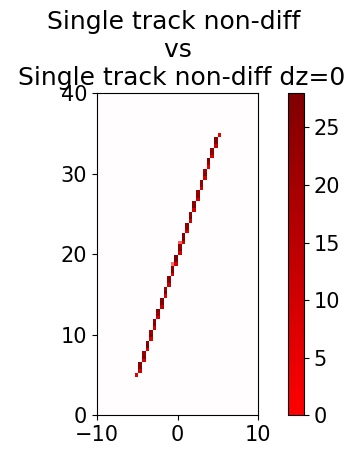

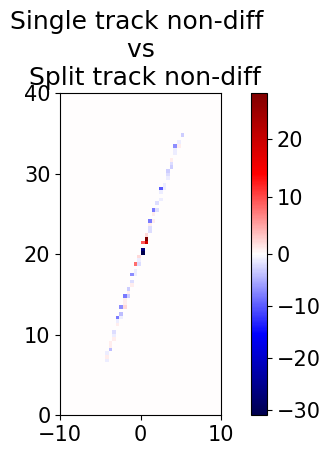

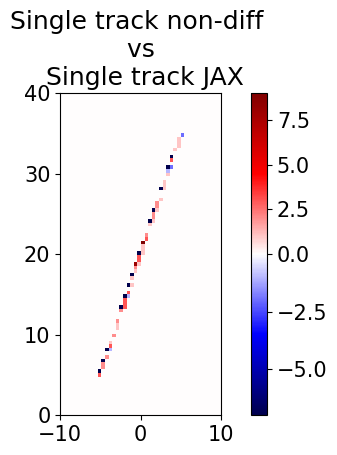

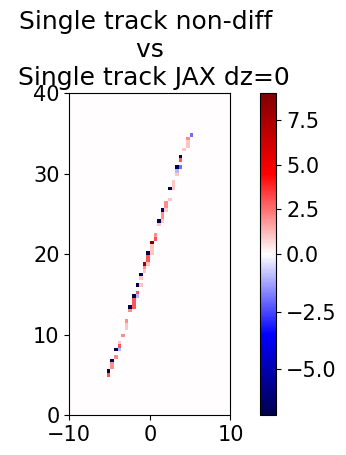

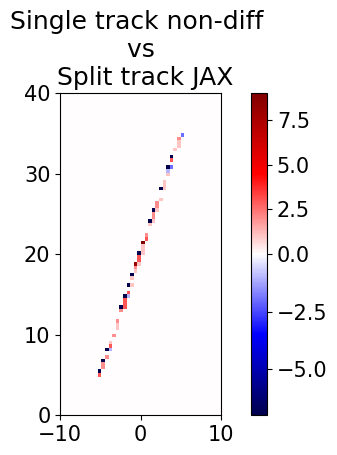

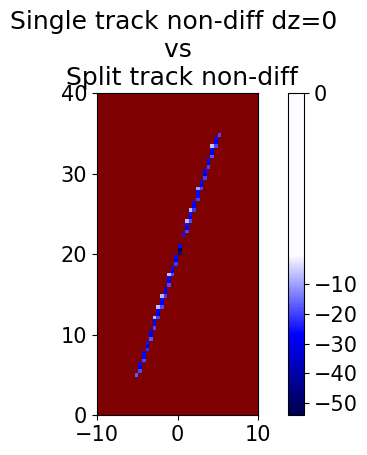

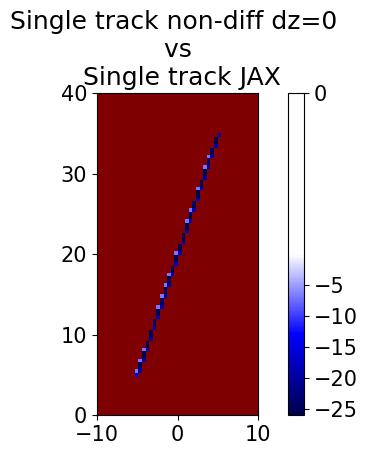

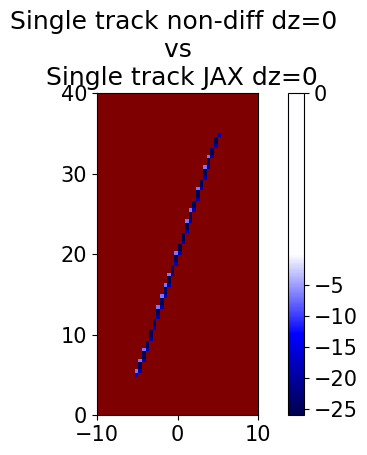

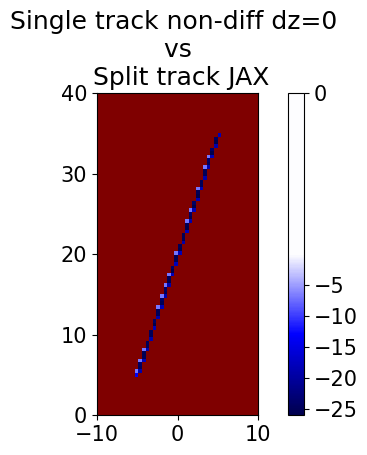

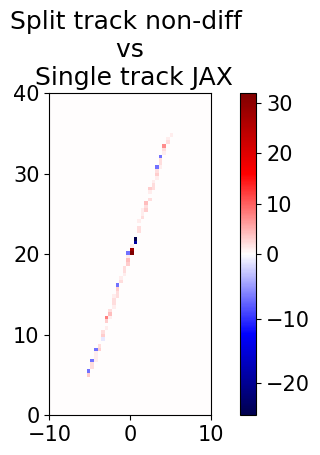

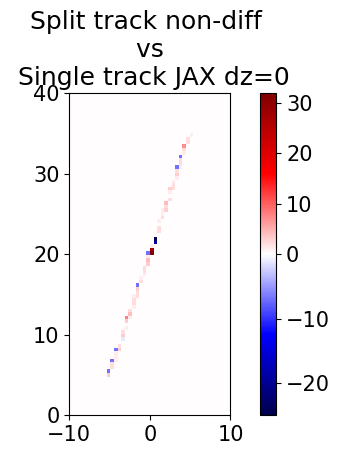

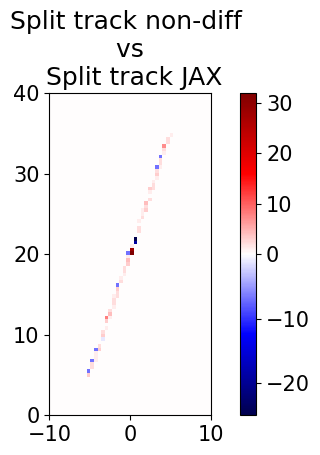

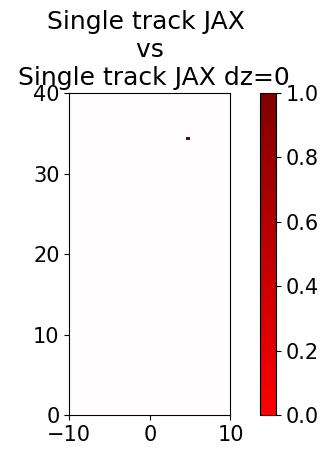

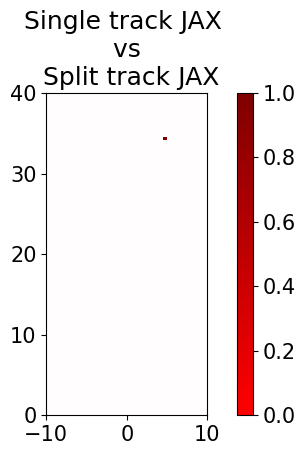

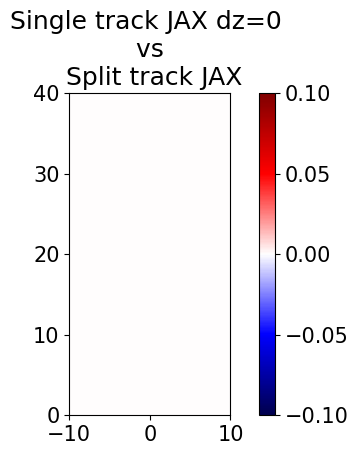

In [17]:
# fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i in range(6):
    for j in range(i + 1, 6):
        # fig = plt.figure()
        # ax = axs[i, j - 1]
        results[i].plot_diff(results[j])
        ax = plt.gca()
        ax.set_title(f"{results[i].title} \n vs \n {results[j].title}")
        ax.set_xlim(-10, 10)
        ax.set_ylim(0, 40)
        plt.tight_layout()
fig.tight_layout()

In [13]:
import pandas as pd
selected_fields = ['x', 'x_start', 'x_end', 'y', 'y_start', 'y_end', 'z', 'z_start', 'z_end', 'dE', 'dx', 'dEdx']

pd.DataFrame(res.tracks)[selected_fields]

,x,x_start,x_end,y,y_start,y_end,z,z_start,z_end,dE,dx,dEdx
0,-2.5,-5.0,0.0,12.5,5.0,20.0,12.005,12.01,12.0,31.622784,15.811392,2.0


In [21]:
import dataclasses
from flax import struct

@dataclasses.dataclass
class Params_data:
    eField: float = struct.field(pytree_node=False)
    Ab: float #= struct.field(pytree_node=False)
    kb: float
    lifetime: float
    vdrift: float = struct.field(pytree_node=False)
    long_diff: float = struct.field(pytree_node=False)
    tran_diff: float = struct.field(pytree_node=False)
    tpc_borders: jax.Array = struct.field(pytree_node=False)
    box: int = struct.field(pytree_node=False)
    birks: int = struct.field(pytree_node=False)
    lArDensity: float = struct.field(pytree_node=False)
    alpha: float = struct.field(pytree_node=False)
    beta: float = struct.field(pytree_node=False)
    MeVToElectrons: float = struct.field(pytree_node=False)
    pixel_pitch: float = struct.field(pytree_node=False)
    n_pixels: tuple = struct.field(pytree_node=False)
    max_radius: int = struct.field(pytree_node=False)
    max_active_pixels: int = struct.field(pytree_node=False)
    drift_length: float = struct.field(pytree_node=False)
    t_sampling: float = struct.field(pytree_node=False)
    time_interval: float = struct.field(pytree_node=False)
    time_padding: float = struct.field(pytree_node=False)
    min_step_size: float = struct.field(pytree_node=False)
    time_max: float = struct.field(pytree_node=False)
    time_window: float = struct.field(pytree_node=False)
    e_charge: float = struct.field(pytree_node=False)
    #: Maximum number of ADC values stored per pixel
    MAX_ADC_VALUES: int = struct.field(pytree_node=False)
    #: Discrimination threshold
    DISCRIMINATION_THRESHOLD: float = struct.field(pytree_node=False)
    #: ADC hold delay in clock cycles
    ADC_HOLD_DELAY: int = struct.field(pytree_node=False)
    #: Clock cycle time in :math:`\mu s`
    CLOCK_CYCLE: float = struct.field(pytree_node=False)
    #: Front-end gain in :math:`mV/ke-`
    GAIN: float = struct.field(pytree_node=False)
    #: Common-mode voltage in :math:`mV`
    V_CM: float = struct.field(pytree_node=False)
    #: Reference voltage in :math:`mV`
    V_REF: float = struct.field(pytree_node=False)
    #: Pedestal voltage in :math:`mV`
    V_PEDESTAL: float = struct.field(pytree_node=False)
    #: Number of ADC counts
    ADC_COUNTS: int = struct.field(pytree_node=False)
    # if readout_noise:
        #: Reset noise in e-
        # self.RESET_NOISE_CHARGE = 900
        # #: Uncorrelated noise in e-
        # self.UNCORRELATED_NOISE_CHARGE = 500
    # else:
    RESET_NOISE_CHARGE: float = struct.field(pytree_node=False)
    UNCORRELATED_NOISE_CHARGE: float = struct.field(pytree_node=False)


In [28]:
from larndsim.consts_jax import consts
csts = consts()
csts.load_detector_properties("/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                                "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

params = {
    "eField": 0.50,
    "Ab": 0.8,
    "kb": 0.0486,
    "vdrift": 0.1648,
    "lifetime": 2.2e3,
    "long_diff": 4.0e-6,
    "tran_diff": 8.8e-6,
    "tpc_borders": jnp.asarray(csts.tpc_borders),
    "box": 1,
    "birks": 2,
    "lArDensity": 1.38,
    "alpha": 0.93,
    "beta": 0.207,
    "MeVToElectrons": 4.237e+04,
    "pixel_pitch": csts.pixel_pitch,
    "n_pixels": csts.n_pixels,
    "drift_length": csts.drift_length,
    # "t_sampling": csts.t_sampling,
    "t_sampling": csts.t_sampling,
    "time_interval": csts.time_interval,
    "time_padding": csts.time_padding,
    "max_active_pixels": 0,
    "max_radius": 0,
    "min_step_size": 0.001, #cm
    "time_max": 0,
    "time_window": 189.1, #us,
    "e_charge": 1.602e-19,
    "MAX_ADC_VALUES": 10,
    "DISCRIMINATION_THRESHOLD": 7e3*1.602e-19,
    "ADC_HOLD_DELAY": 15,
    "CLOCK_CYCLE": 0.1,
    "GAIN": 4e-3,
    "V_CM": 288,
    "V_REF": 1300,
    "V_PEDESTAL": 580,
    "ADC_COUNTS": 2**8,
    "RESET_NOISE_CHARGE": 0,
    "UNCORRELATED_NOISE_CHARGE": 0,
    }

test = Params_data(**params)

In [30]:
dataclasses.fields(Params_data)

(Field(name='eField',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,default_factory=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'pytree_node': False}),kw_only=False,_field_type=_FIELD),
 Field(name='Ab',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,default_factory=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='kb',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,default_factory=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='lifetime',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7f5ff92a3970>,default_factory=<dataclasses._MISSING_TYPE object at 0x